In [46]:
# Import libraries
import os
import pprint
import numpy as np
import wandb
import torch
import torch.nn as nn
import time
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils import *
from models import FCN
# Ensure reproducibility
torch.backends.cudnn.deterministic = True
seed_no = 108
np.random.seed(hash("improves reproducibility") % seed_no)
torch.manual_seed(hash("by removing stochasticity") % seed_no)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % seed_no)
# Device configuration
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [47]:
class CAE(nn.Module):
    def __init__(self, dim, h_dim):
        super(CAE, self).__init__()
        self.dim = dim
        self.h_dim = h_dim

        # Encoder
        self.encoder = nn.Sequential(
                nn.Conv2d(1, self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(self.dim),

                nn.Conv2d(self.dim, 2 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(2 * self.dim),

                nn.Conv2d(2 * self.dim, 4 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(4 * self.dim),

                nn.Conv2d(4 * self.dim, 8 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(8 * self.dim)
            )
    
        # Bottleneck
        self.bottleneck = nn.Sequential(
                nn.Linear(self.dim * 32, self.h_dim),
                nn.LeakyReLU(0.25),
                nn.BatchNorm1d(self.h_dim),

                nn.Linear(self.h_dim, self.dim * 32),
                nn.LeakyReLU(0.25),
                nn.BatchNorm1d(self.dim * 32)

            )

    
        # Decoder
        self.decoder = nn.Sequential(
                nn.ConvTranspose2d(8 * self.dim, 4 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(4 * self.dim),

                nn.ConvTranspose2d(4 * self.dim, 2 * self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(2 * self.dim),

                nn.ConvTranspose2d(2 * self.dim, self.dim, 4, 2, 1),
                nn.LeakyReLU(0.25),
                nn.BatchNorm2d(self.dim),

                nn.ConvTranspose2d(self.dim, 1, 4, 2, 1),
                nn.LeakyReLU(0.25)
            )
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.reshape(x, (-1, self.dim * 32))
        x = self.bottleneck(x)
        x = torch.reshape(x, (-1, self.dim * 8, 2, 2))
        output = self.decoder(x)
        return output


In [48]:
# Loading the data
permeability = np.load("hw6_data/permeability.npy")
pressure = np.load("hw6_data/pressure.npy")

# Normalize the data between -1 and 1
permeability = ((permeability - permeability.min())/(permeability.max()-permeability.min()))*2 - 1.
pressure = ((pressure - pressure.min())/(pressure.max()-pressure.min()))*2 - 1.

# Hyperparameters
num_epochs = 150
log_freq = int(0.1 * num_epochs)
n_train = int(0.8 * permeability.shape[0])

# Data loader
train_permeability = torch.from_numpy(permeability[:n_train, :, :]).float().to(device)
train_pressure = torch.from_numpy(pressure[:n_train, :, :]).float().to(device)

val_permeability = torch.from_numpy(permeability[n_train:, :, :]).float().to(device)
val_pressure = torch.from_numpy(pressure[n_train:, :, :]).float().to(device)

train_dataset = torch.utils.data.TensorDataset(train_permeability, train_pressure)
test_dataset = torch.utils.data.TensorDataset(val_permeability, val_pressure)

In [49]:
#wandb hyperparameter dictionary
sweep_configuration = {
    "method": "grid",
    "name": "grid_search",
    "metric": {"goal": "minimize", "name": "val_loss"},
    "parameters": 
    {
        "dim": {"values": [16.0, 32.0, 64.0]},
        "h_dim": {"values": [64.0, 128.0, 256.0]},
        "lr": {"values": [0.001]},
        "reg_param": {"values": [0.0]},
        "batch_size": {"values": [1024]}
     }
}
pprint.pprint(sweep_configuration)
project_name = "cme216_hw6"
group_name = "grid_search_hw6"
sweep_id = wandb.sweep(sweep_configuration, project=project_name)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'name': 'grid_search',
 'parameters': {'batch_size': {'values': [1024]},
                'dim': {'values': [16.0, 32.0, 64.0]},
                'h_dim': {'values': [64.0, 128.0, 256.0]},
                'lr': {'values': [0.001]},
                'reg_param': {'values': [0.0]}}}
Create sweep with ID: oxl0v4to
Sweep URL: https://wandb.ai/abroze/cme216_hw6/sweeps/oxl0v4to


wandb: Agent Starting Run: foeb63d0 with config:
wandb: 	batch_size: 1024
wandb: 	dim: 16
wandb: 	h_dim: 64
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.4752, Validation Loss: 0.4698,                     Val. error (in %) = 91.04%
Epoch [30/150], Step [4/4],                     Training Loss: 0.3195, Validation Loss: 0.3075,                     Val. error (in %) = 73.83%
Epoch [45/150], Step [4/4],                     Training Loss: 0.0893, Validation Loss: 0.0835,                     Val. error (in %) = 38.58%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0127, Validation Loss: 0.0132,                     Val. error (in %) = 15.34%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0055, Validation Loss: 0.0056,                     Val. error (in %) = 9.93%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0040, Validation Loss: 0.0046,                     Val. error (in %) = 8.94%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0041, Validation Loss: 0.0036,                     Val. error (in %) = 7.83%
E

wandb: Agent Starting Run: vwbq0cji with config:
wandb: 	batch_size: 1024
wandb: 	dim: 16
wandb: 	h_dim: 128
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.4516, Validation Loss: 0.4458,                     Val. error (in %) = 88.61%
Epoch [30/150], Step [4/4],                     Training Loss: 0.2677, Validation Loss: 0.2558,                     Val. error (in %) = 67.35%
Epoch [45/150], Step [4/4],                     Training Loss: 0.0639, Validation Loss: 0.0562,                     Val. error (in %) = 31.63%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0089, Validation Loss: 0.0087,                     Val. error (in %) = 12.31%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0046, Validation Loss: 0.0049,                     Val. error (in %) = 9.18%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0040, Validation Loss: 0.0041,                     Val. error (in %) = 8.39%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0031, Validation Loss: 0.0031,                     Val. error (in %) = 7.32%
E

wandb: Agent Starting Run: fvgn6q1k with config:
wandb: 	batch_size: 1024
wandb: 	dim: 16
wandb: 	h_dim: 256
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/Users/albanbroze/Documents/Github/CME216-Homework/CME216-Machine-Learning-Homework/Homework6/utils.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(4, 5, figsize=(15, 12))


Epoch [15/150], Step [4/4],                     Training Loss: 0.5069, Validation Loss: 0.5107,                     Val. error (in %) = 94.84%
Epoch [30/150], Step [4/4],                     Training Loss: 0.3610, Validation Loss: 0.3599,                     Val. error (in %) = 79.47%
Epoch [45/150], Step [4/4],                     Training Loss: 0.1187, Validation Loss: 0.1125,                     Val. error (in %) = 44.70%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0181, Validation Loss: 0.0188,                     Val. error (in %) = 18.28%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0057, Validation Loss: 0.0069,                     Val. error (in %) = 10.97%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0040, Validation Loss: 0.0044,                     Val. error (in %) = 8.73%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0031, Validation Loss: 0.0036,                     Val. error (in %) = 7.87%


wandb: Agent Starting Run: nl97w6uq with config:
wandb: 	batch_size: 1024
wandb: 	dim: 32
wandb: 	h_dim: 64
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.4530, Validation Loss: 0.4438,                     Val. error (in %) = 88.33%
Epoch [30/150], Step [4/4],                     Training Loss: 0.1454, Validation Loss: 0.1395,                     Val. error (in %) = 49.66%
Epoch [45/150], Step [4/4],                     Training Loss: 0.0195, Validation Loss: 0.0167,                     Val. error (in %) = 17.20%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0075, Validation Loss: 0.0068,                     Val. error (in %) = 10.79%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0047, Validation Loss: 0.0057,                     Val. error (in %) = 9.85%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0035, Validation Loss: 0.0037,                     Val. error (in %) = 7.85%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0030, Validation Loss: 0.0030,                     Val. error (in %) = 7.15%
E

wandb: Agent Starting Run: ue1d6w3v with config:
wandb: 	batch_size: 1024
wandb: 	dim: 32
wandb: 	h_dim: 128
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.4519, Validation Loss: 0.4588,                     Val. error (in %) = 89.85%
Epoch [30/150], Step [4/4],                     Training Loss: 0.1369, Validation Loss: 0.1251,                     Val. error (in %) = 47.11%
Epoch [45/150], Step [4/4],                     Training Loss: 0.0175, Validation Loss: 0.0133,                     Val. error (in %) = 15.35%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0061, Validation Loss: 0.0059,                     Val. error (in %) = 10.04%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0050, Validation Loss: 0.0050,                     Val. error (in %) = 9.32%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0030, Validation Loss: 0.0039,                     Val. error (in %) = 8.13%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0027, Validation Loss: 0.0031,                     Val. error (in %) = 7.25%
E

wandb: Agent Starting Run: o1741tcf with config:
wandb: 	batch_size: 1024
wandb: 	dim: 32
wandb: 	h_dim: 256
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.4389, Validation Loss: 0.4352,                     Val. error (in %) = 87.47%
Epoch [30/150], Step [4/4],                     Training Loss: 0.1399, Validation Loss: 0.1178,                     Val. error (in %) = 45.72%
Epoch [45/150], Step [4/4],                     Training Loss: 0.0168, Validation Loss: 0.0153,                     Val. error (in %) = 16.50%
Epoch [60/150], Step [4/4],                     Training Loss: 0.0060, Validation Loss: 0.0058,                     Val. error (in %) = 10.03%
Epoch [75/150], Step [4/4],                     Training Loss: 0.0039, Validation Loss: 0.0039,                     Val. error (in %) = 8.14%
Epoch [90/150], Step [4/4],                     Training Loss: 0.0040, Validation Loss: 0.0036,                     Val. error (in %) = 7.83%
Epoch [105/150], Step [4/4],                     Training Loss: 0.0028, Validation Loss: 0.0032,                     Val. error (in %) = 7.46%
E

wandb: Agent Starting Run: gsxde181 with config:
wandb: 	batch_size: 1024
wandb: 	dim: 64
wandb: 	h_dim: 64
wandb: 	lr: 0.001
wandb: 	reg_param: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch [15/150], Step [4/4],                     Training Loss: 0.2082, Validation Loss: 0.2051,                     Val. error (in %) = 60.06%
Epoch [30/150], Step [4/4],                     Training Loss: 0.0316, Validation Loss: 0.0190,                     Val. error (in %) = 18.30%


wandb: Ctrl + C detected. Stopping sweep.


Total time taken: 4928.415759801865


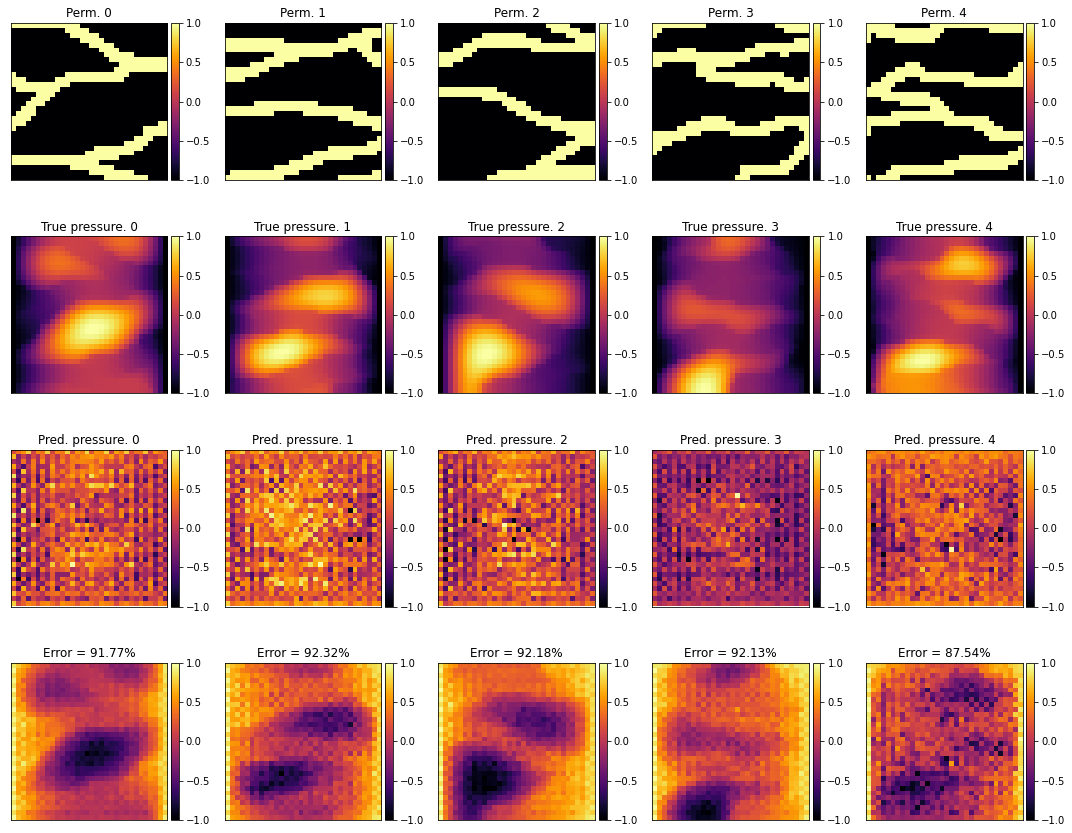

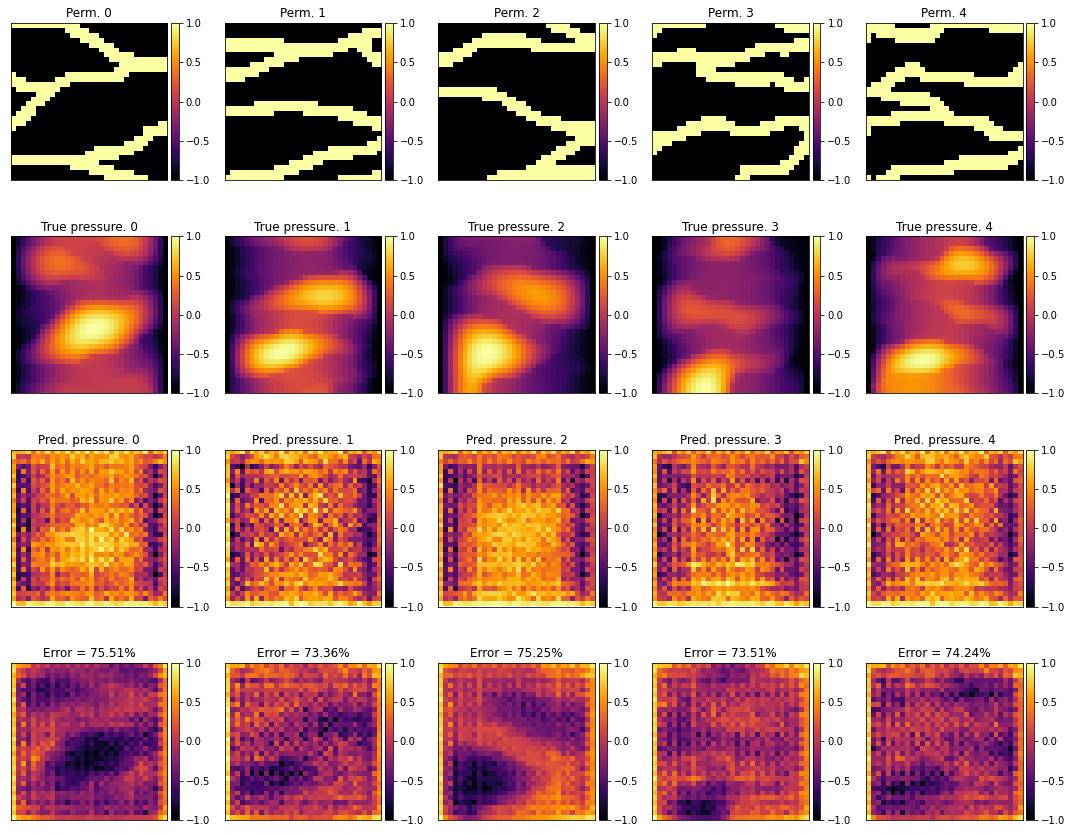

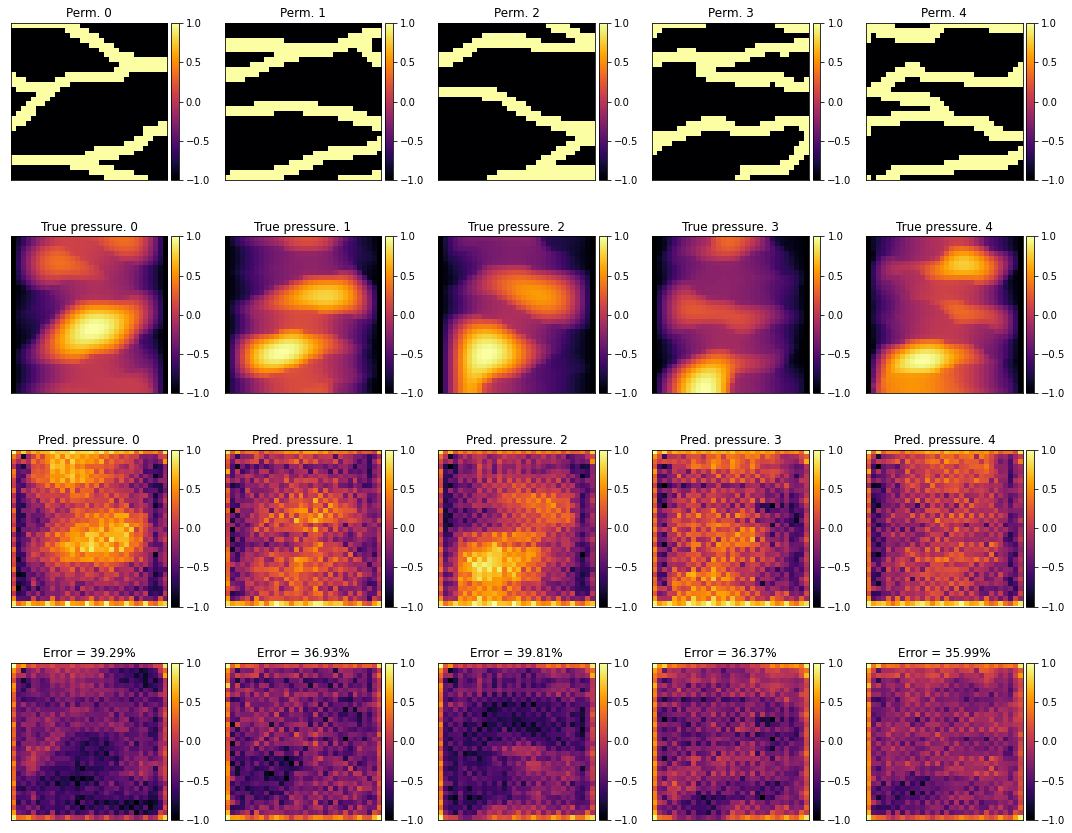

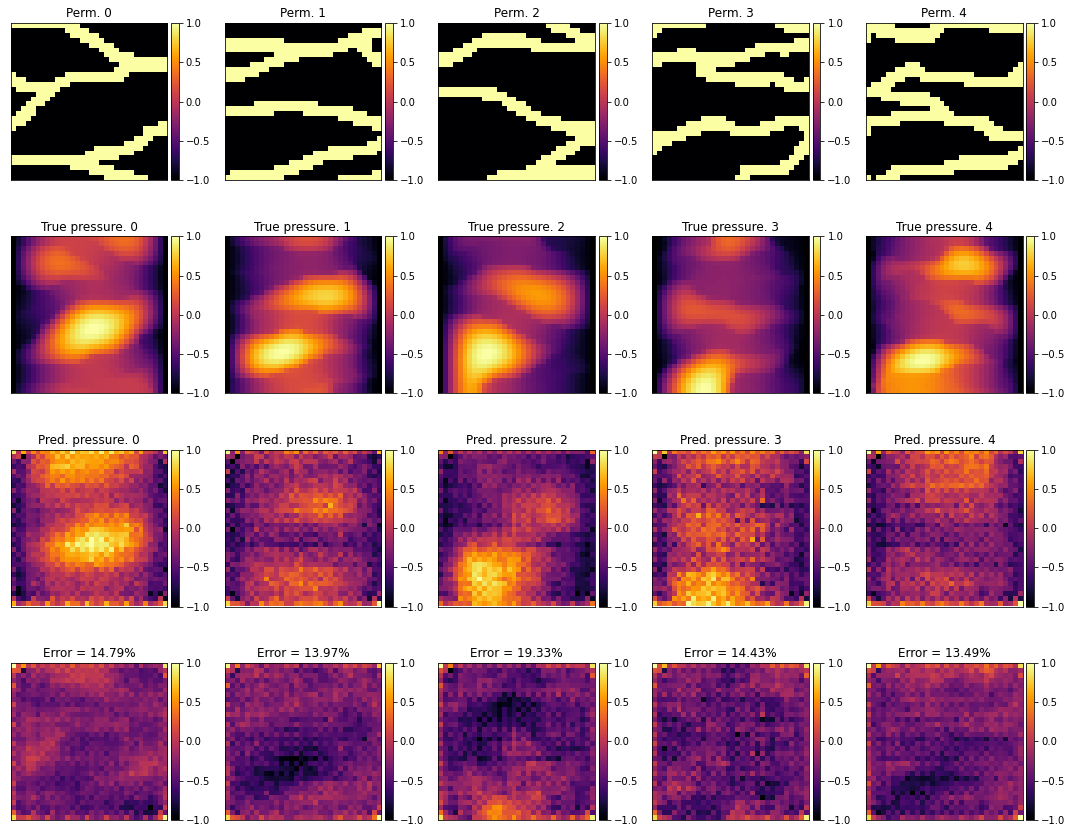

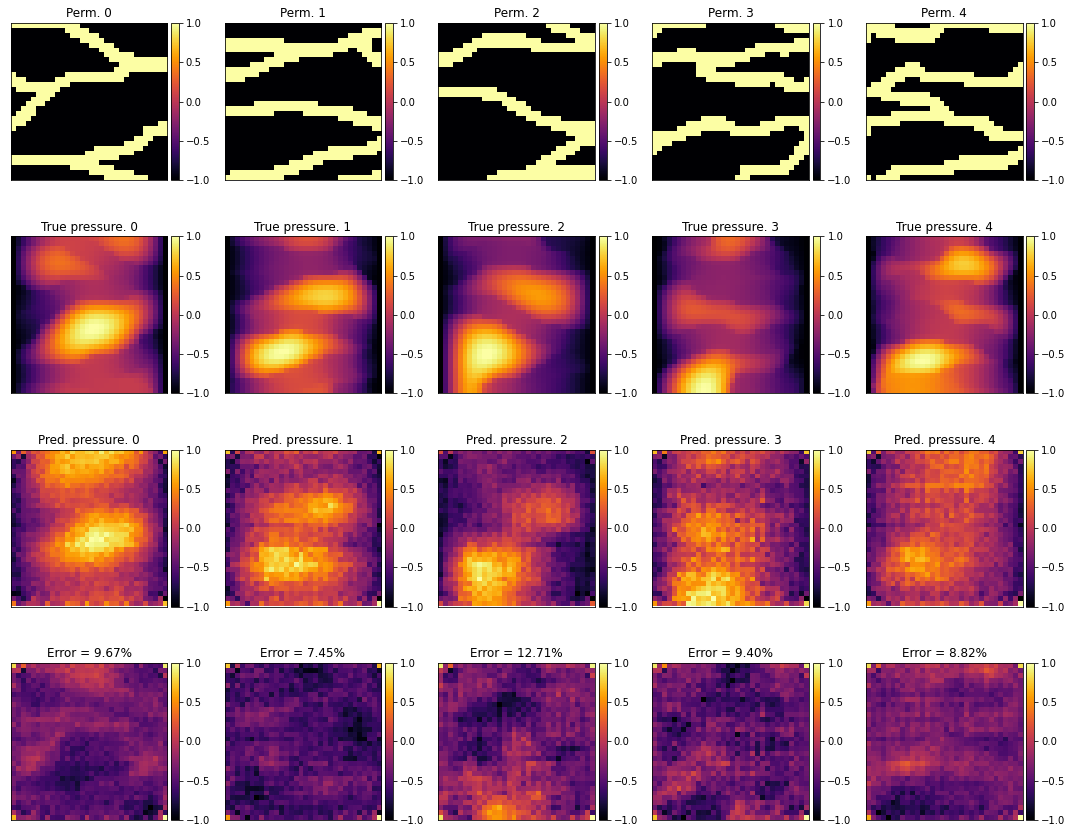

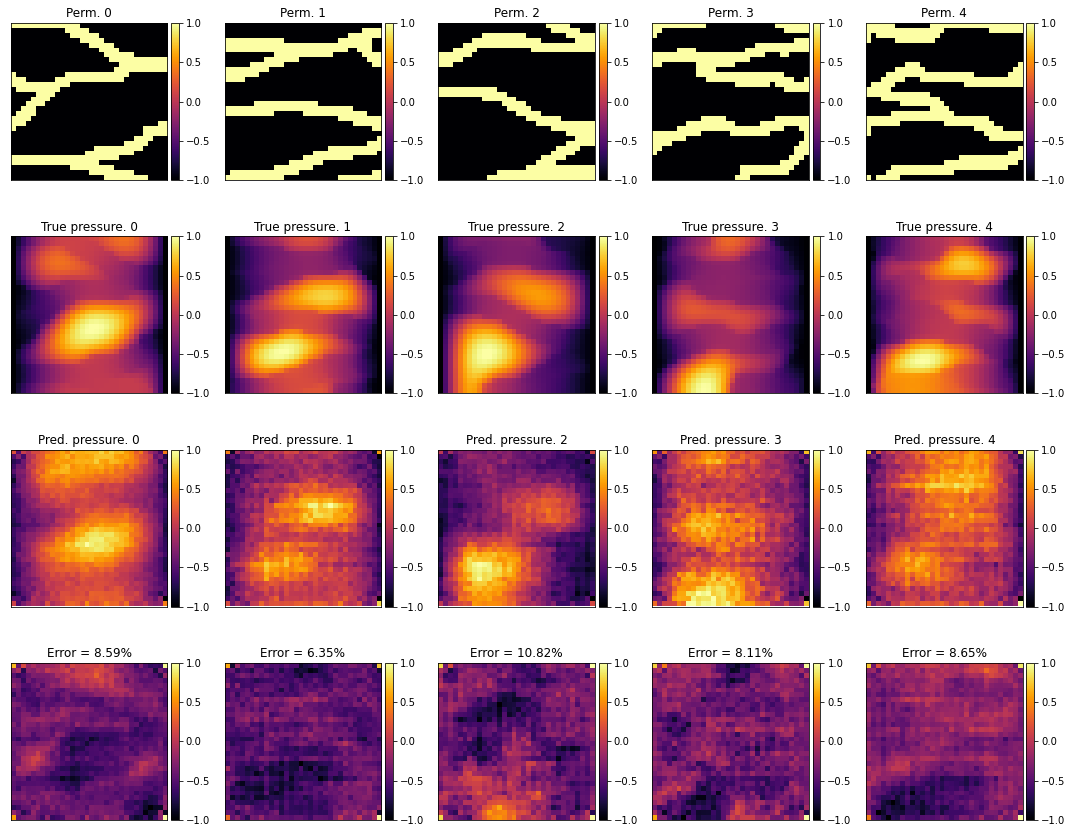

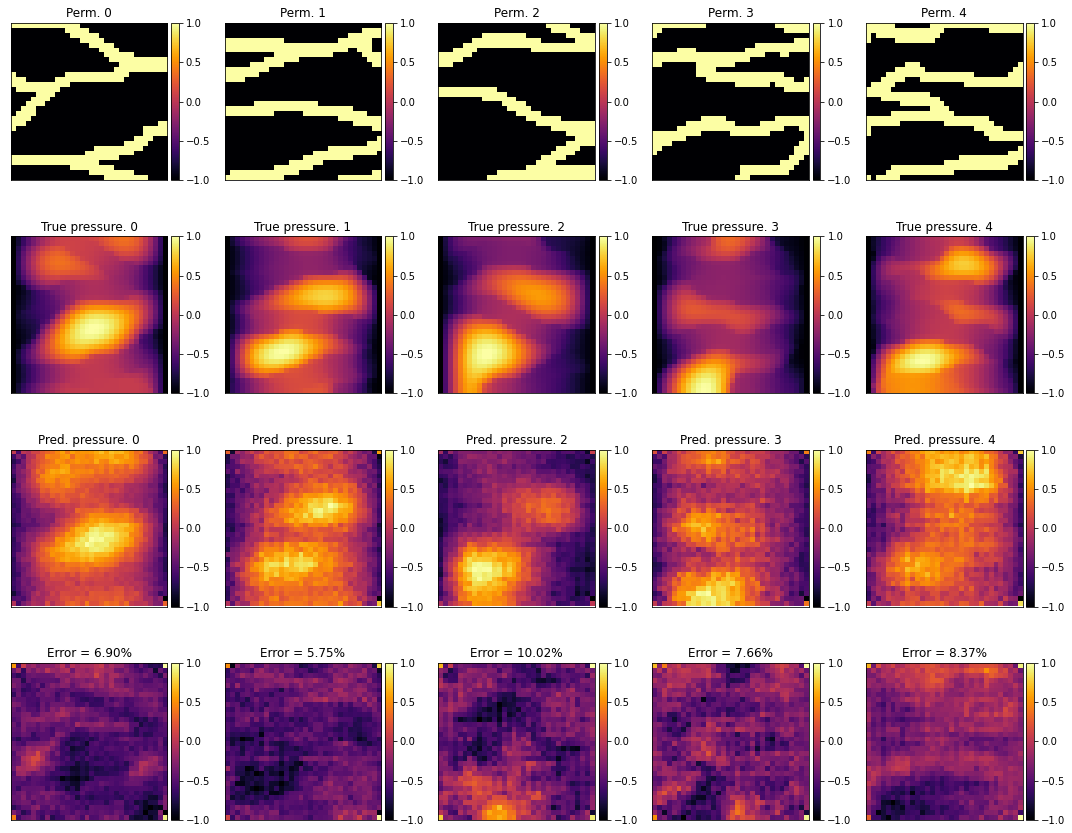

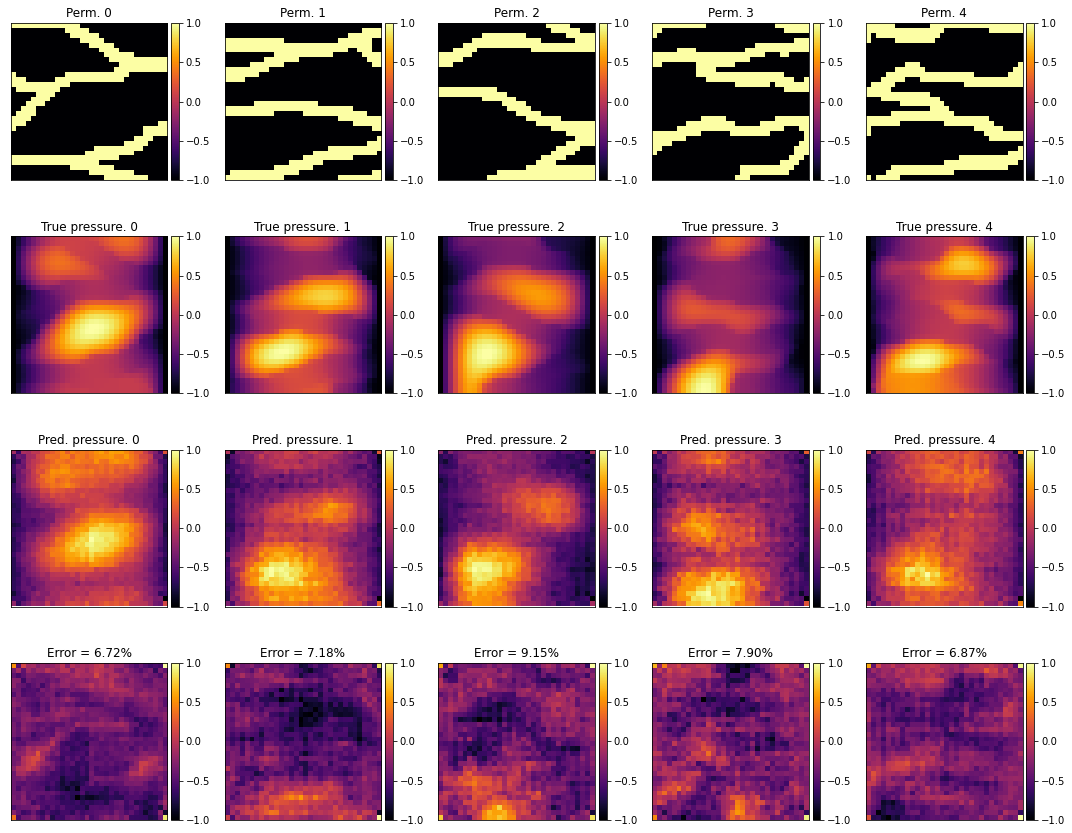

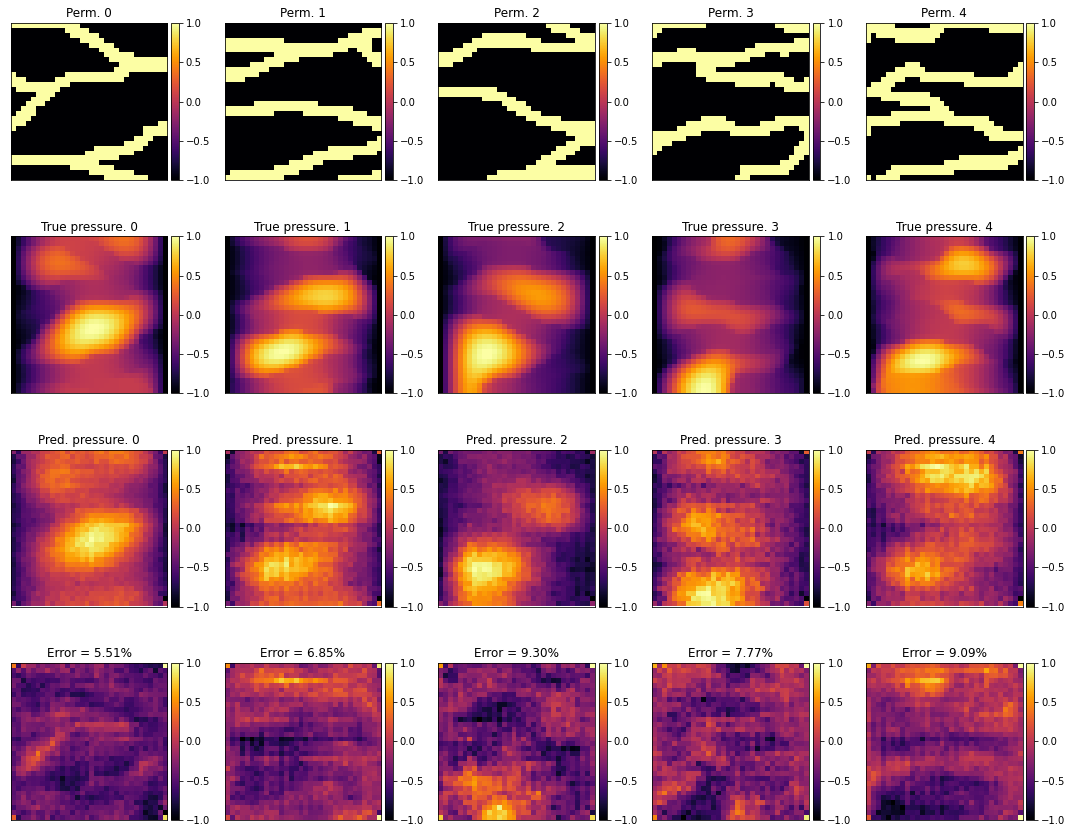

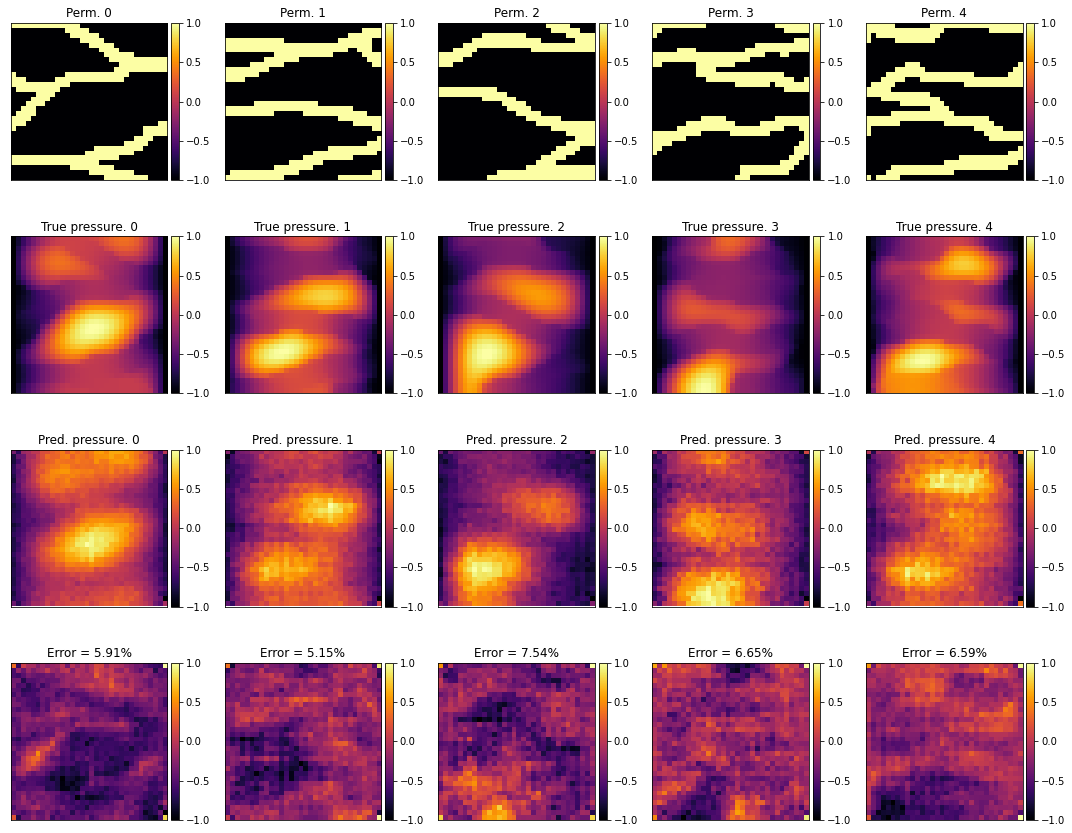

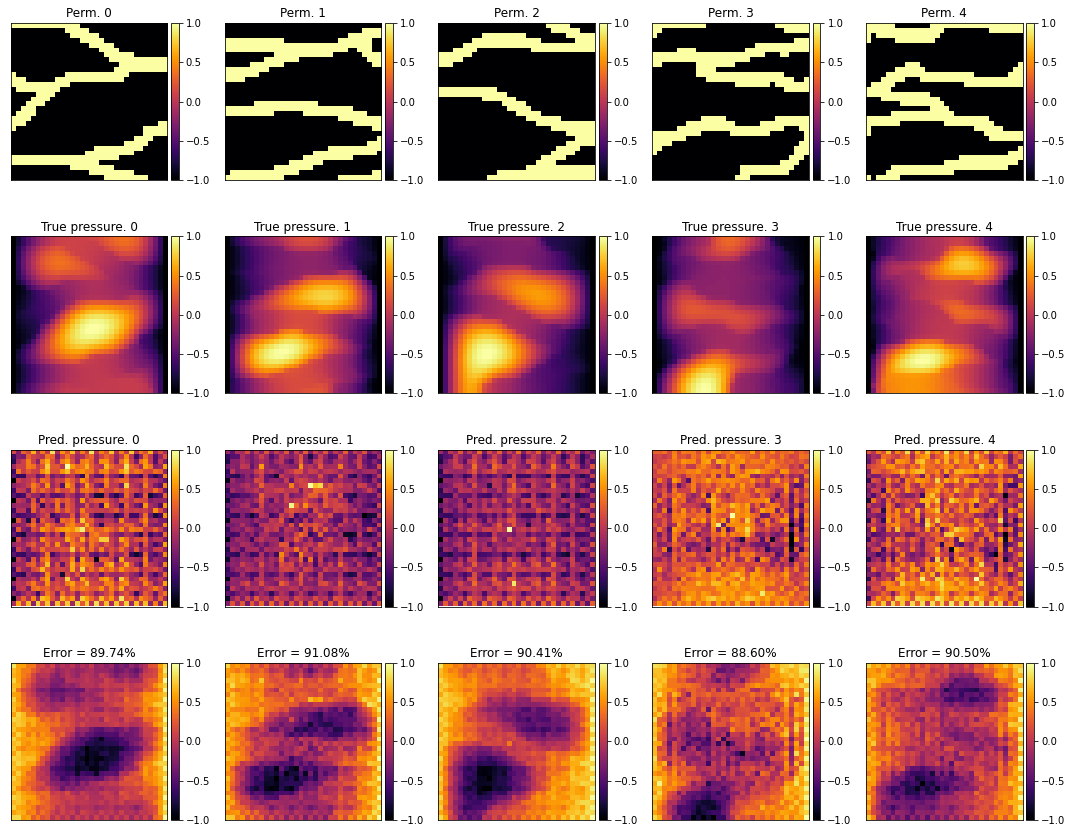

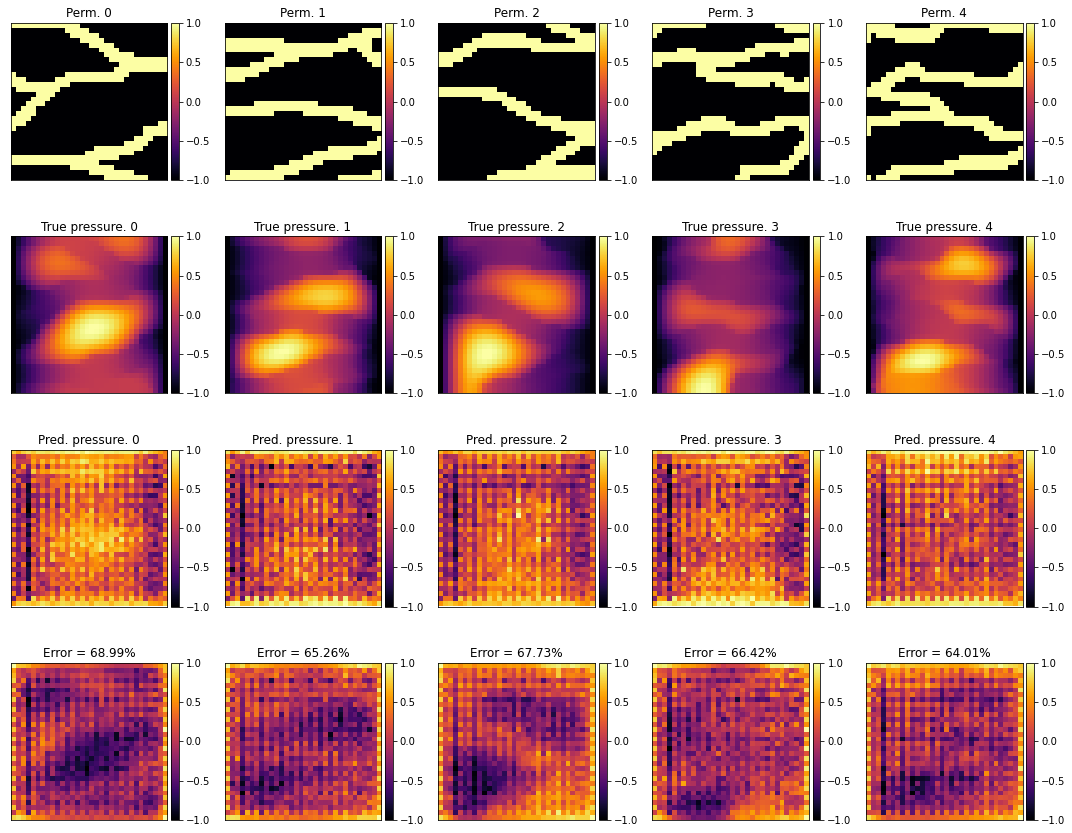

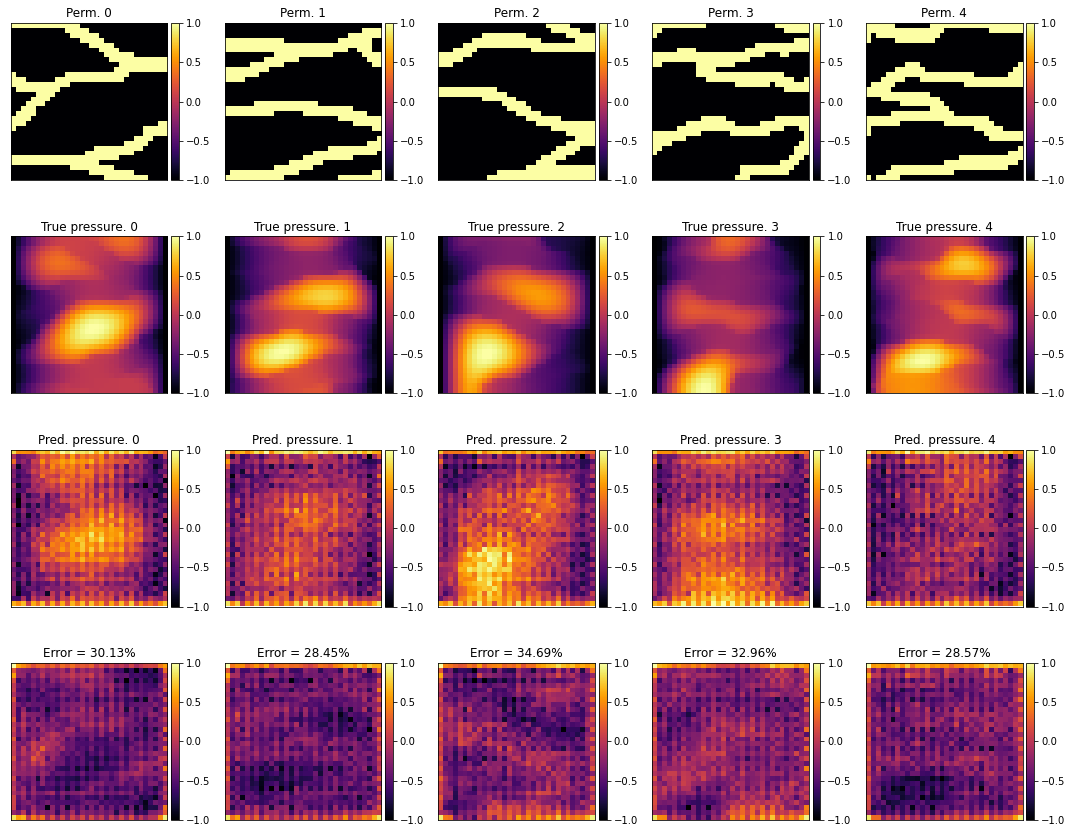

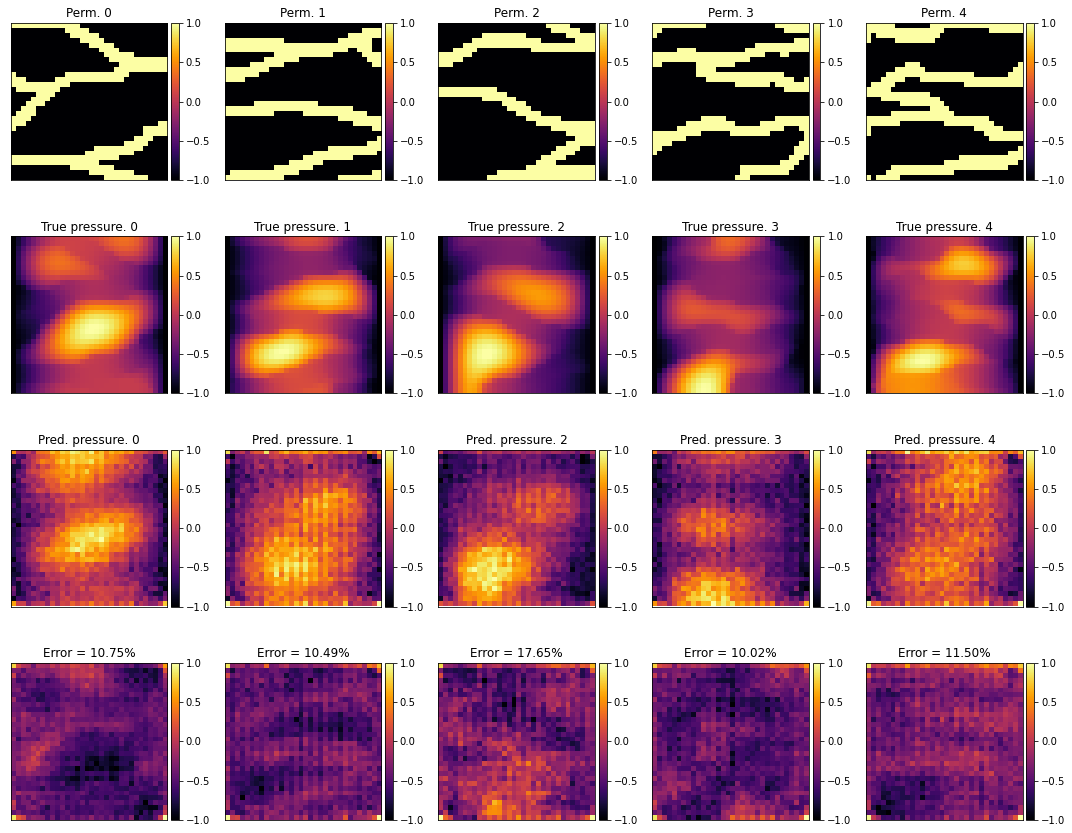

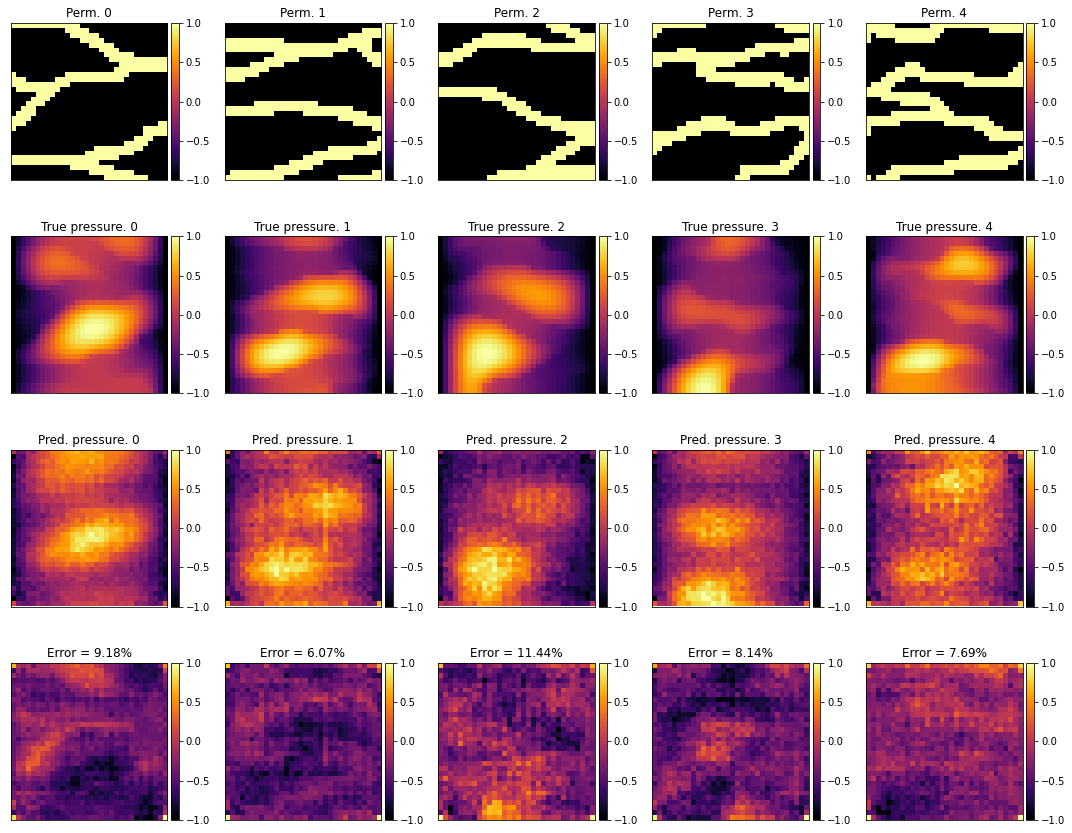

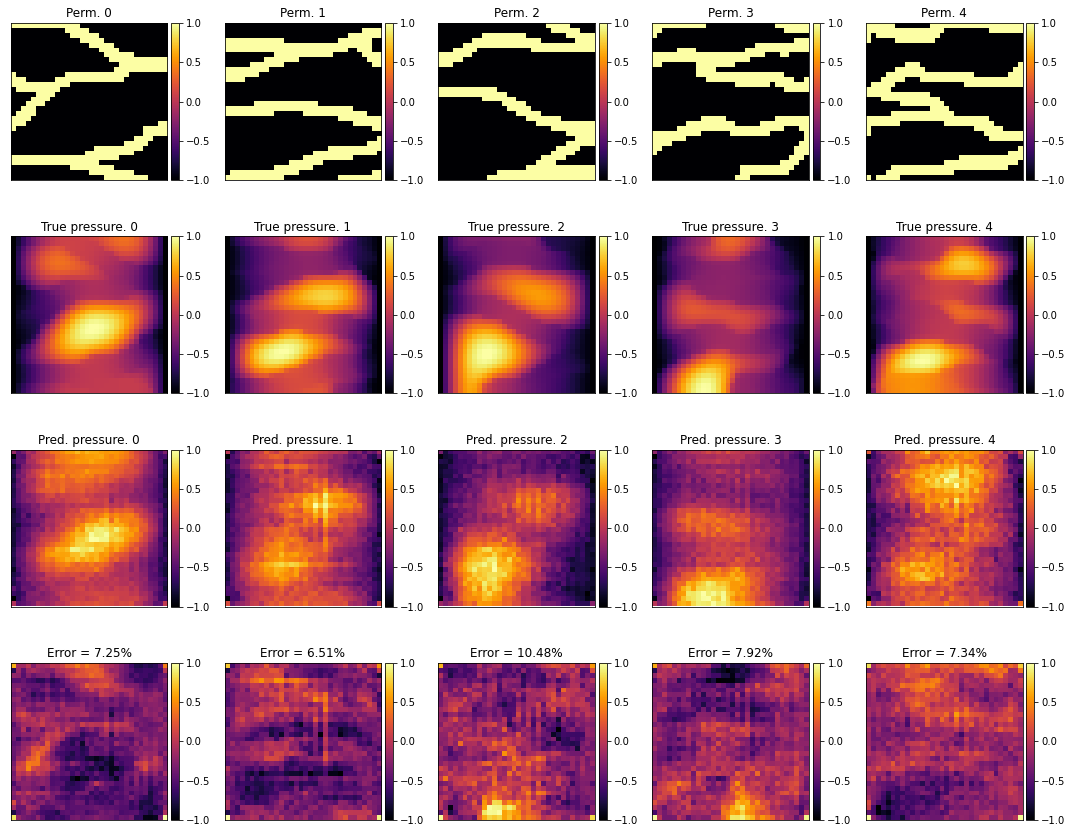

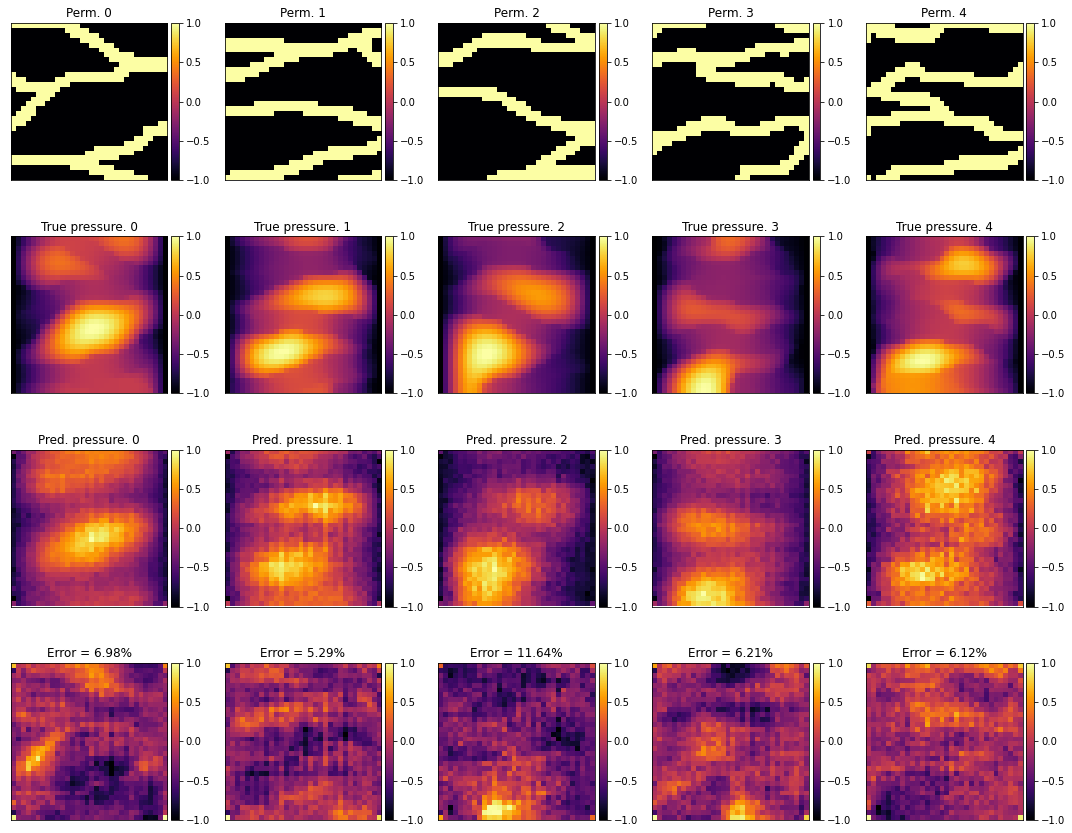

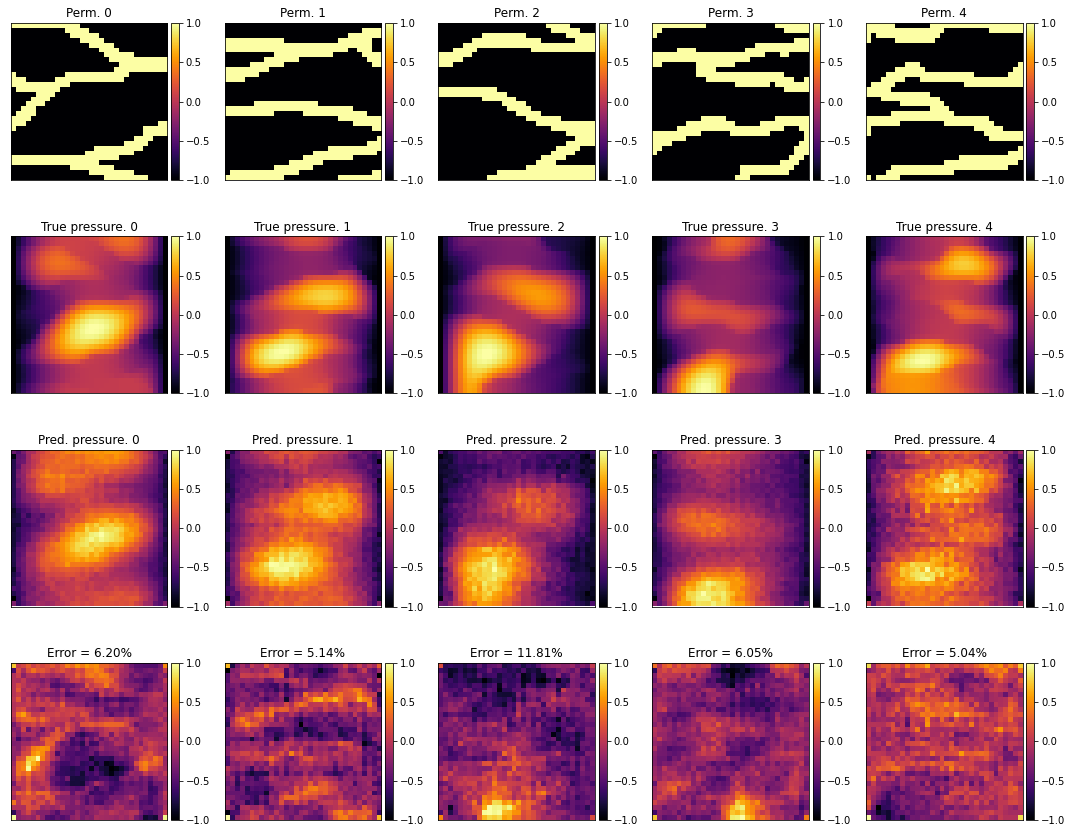

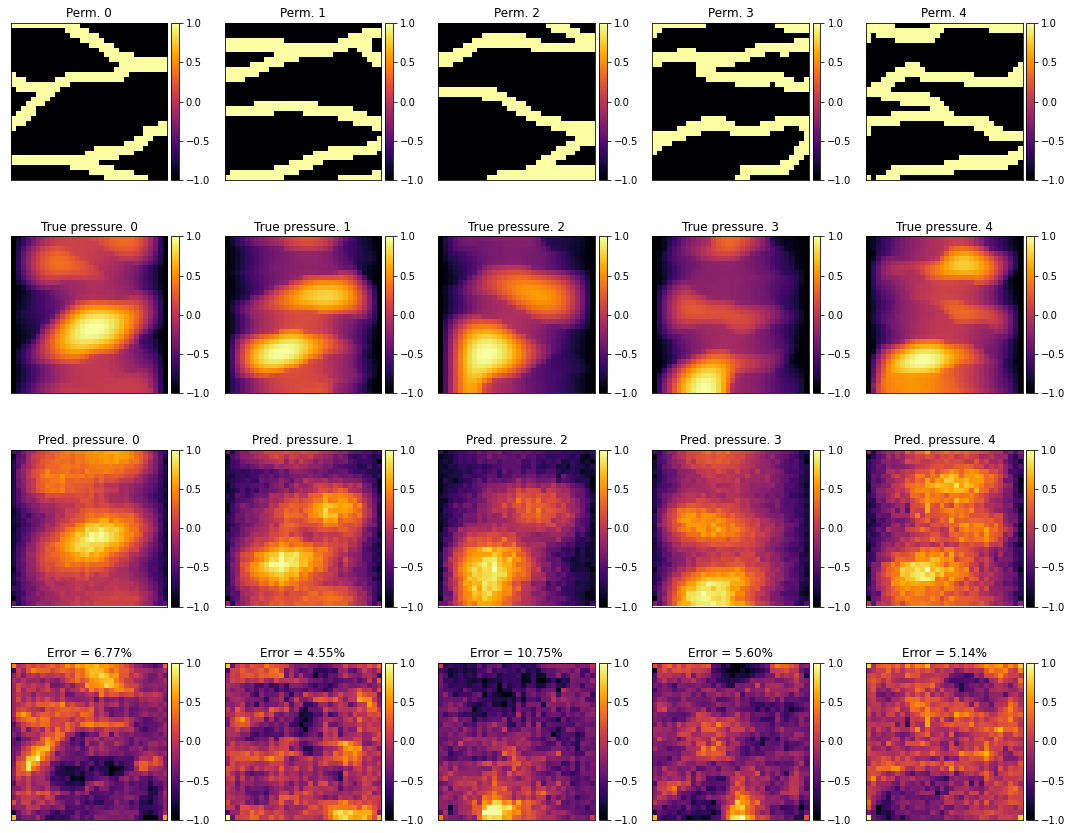

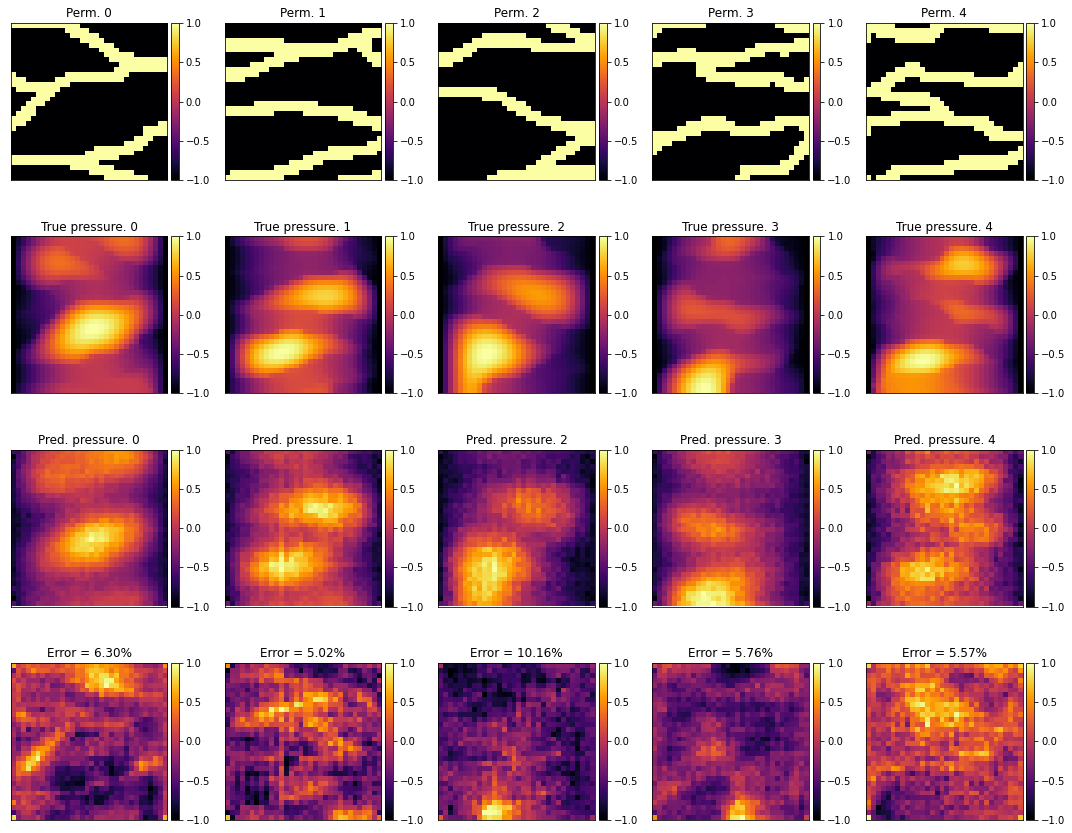

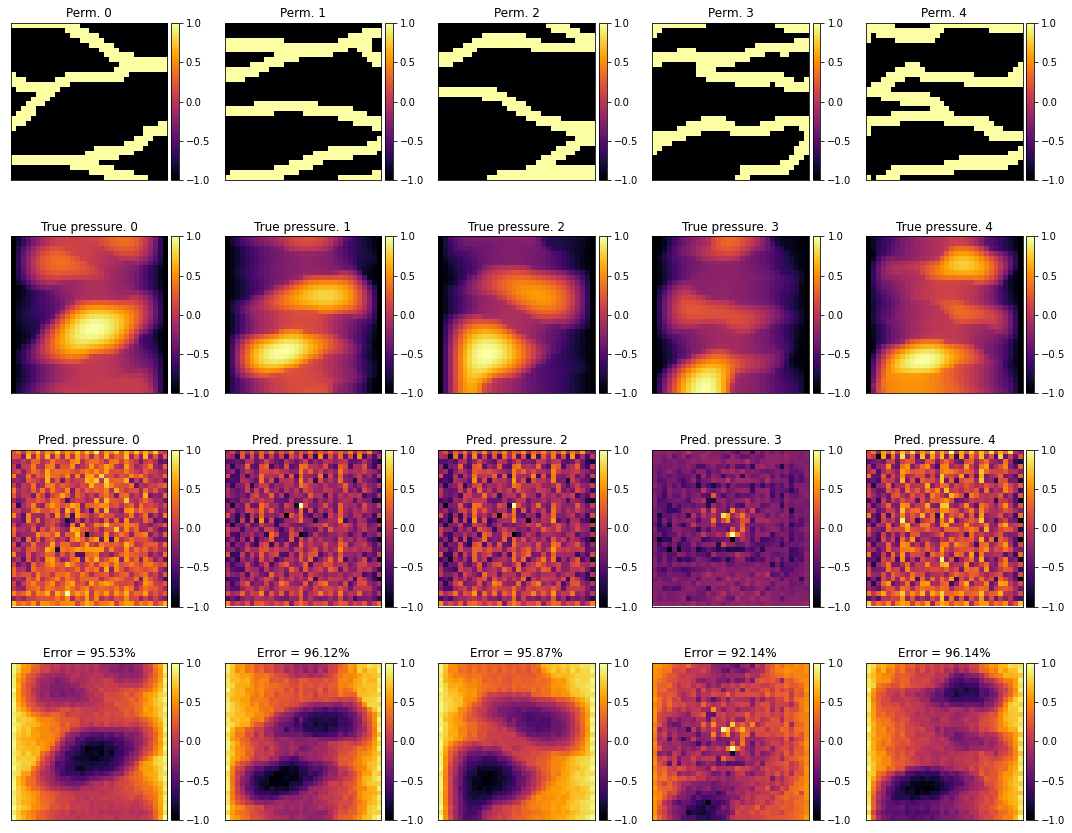

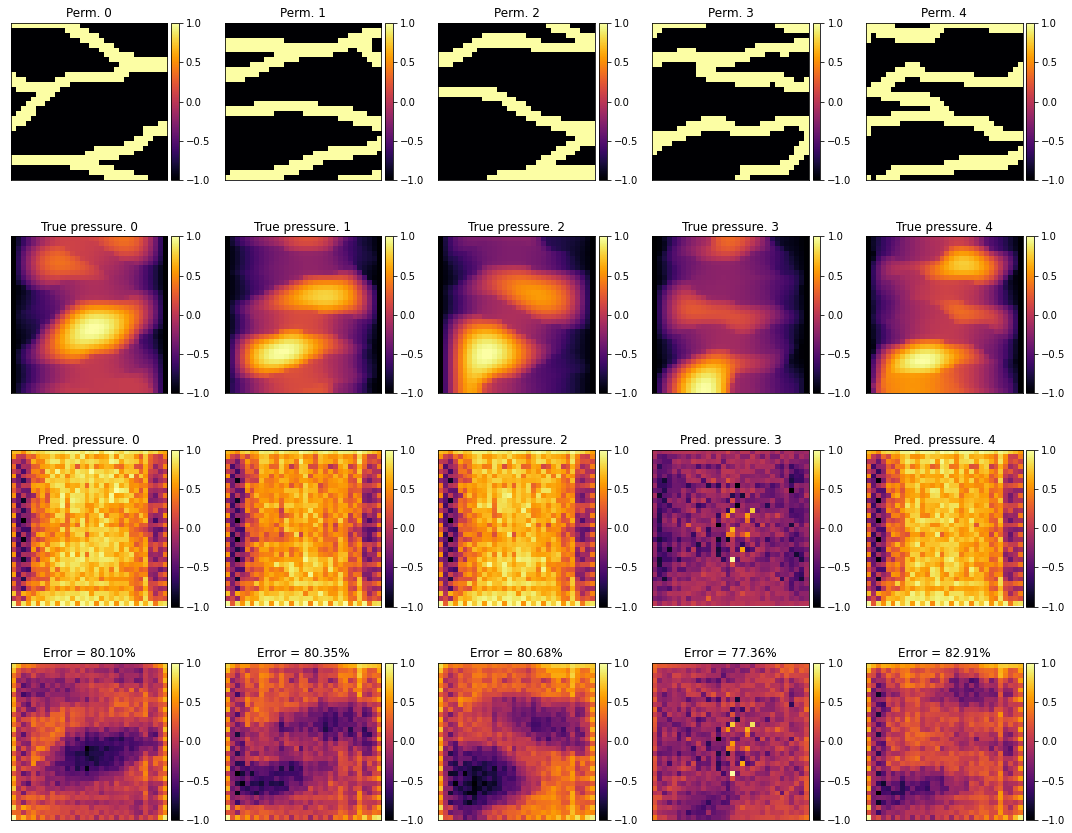

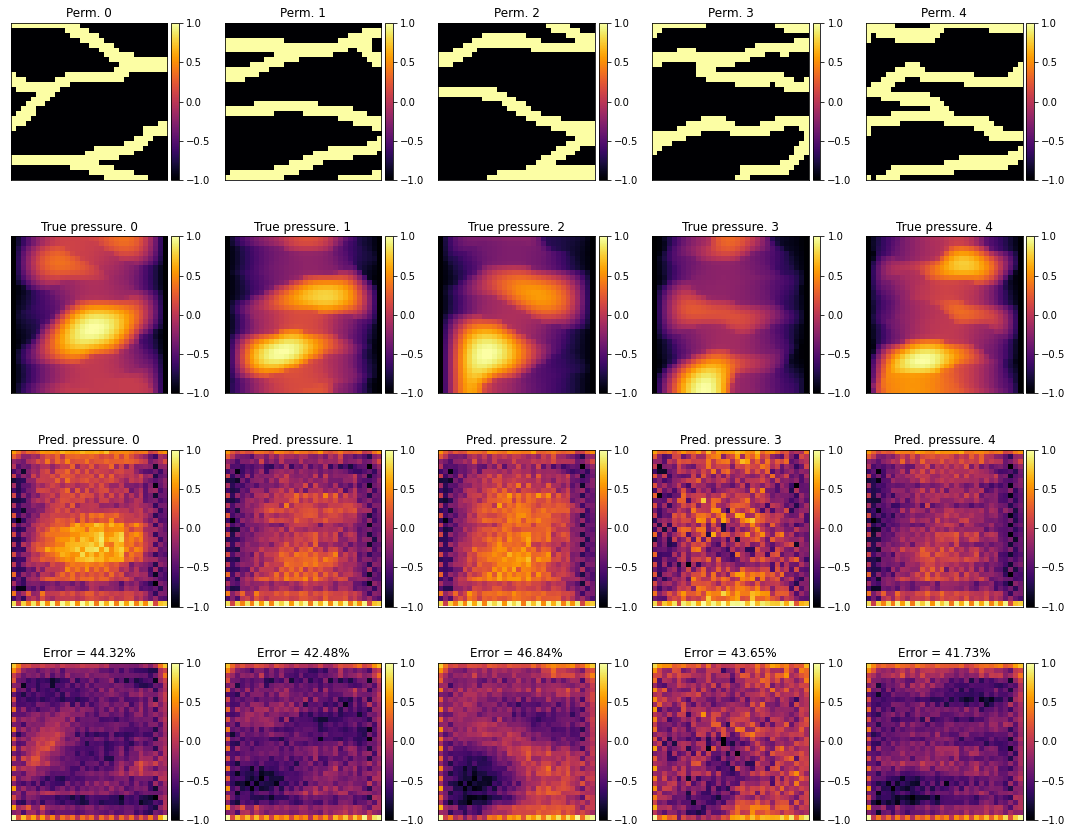

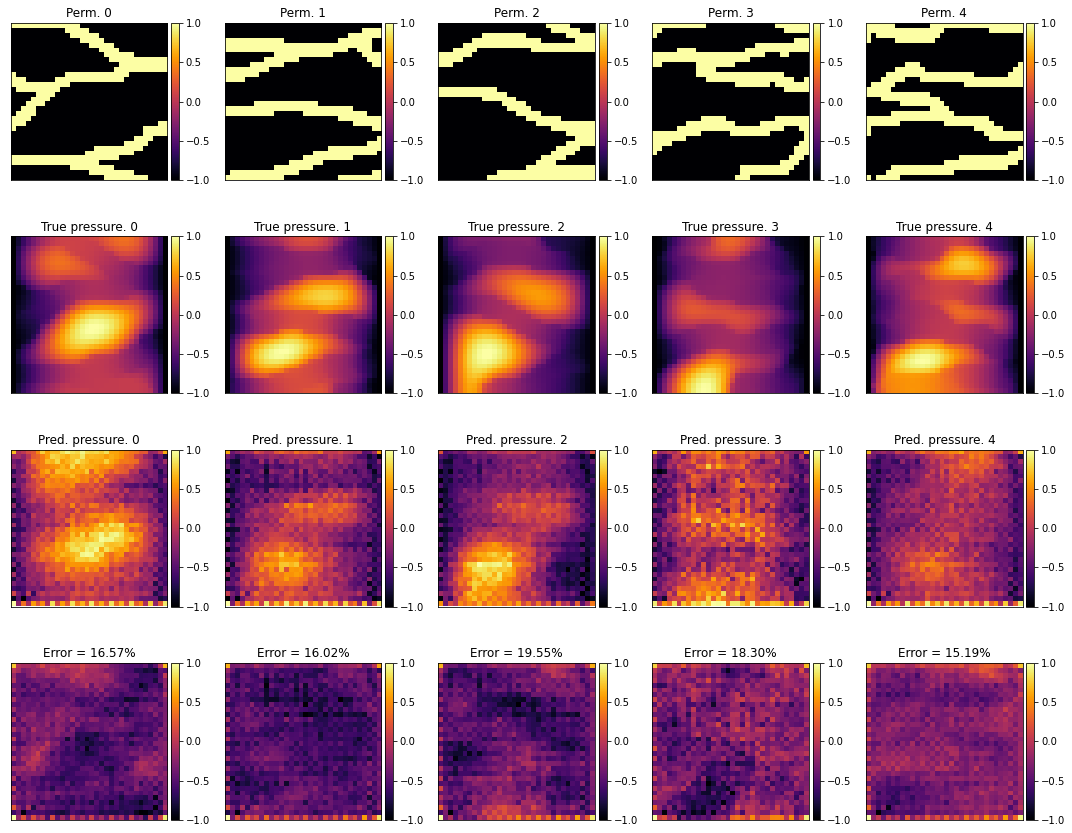

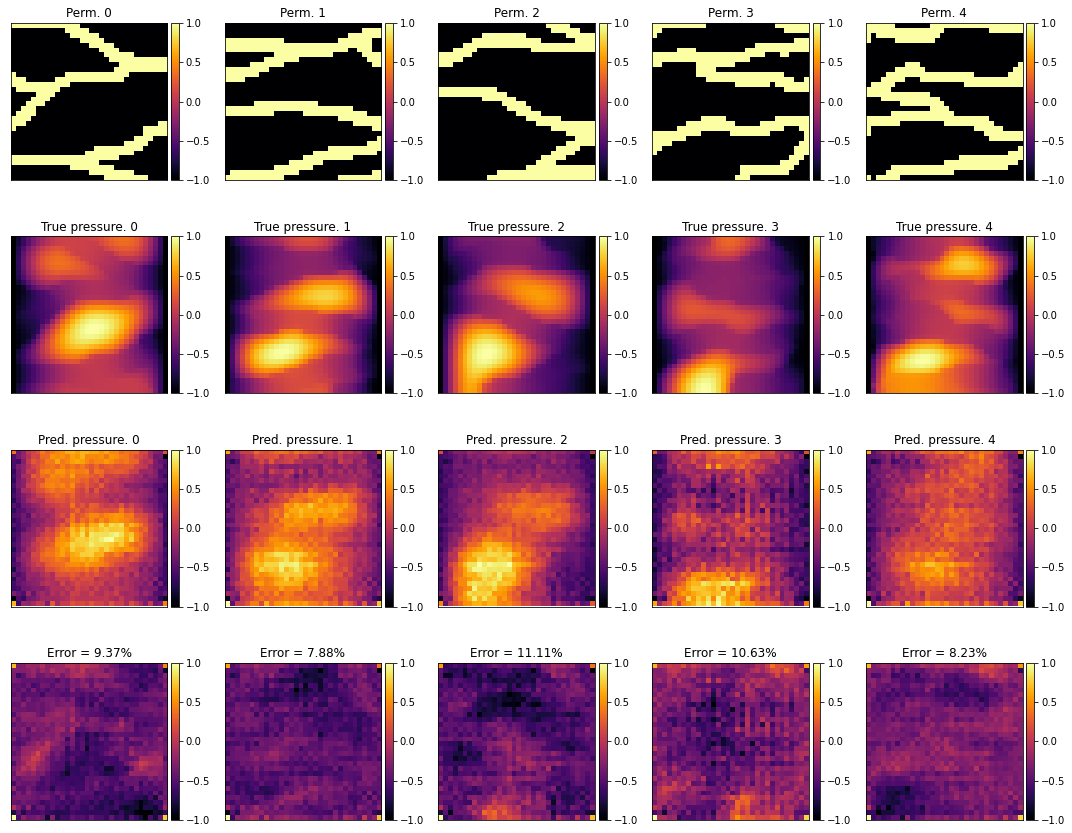

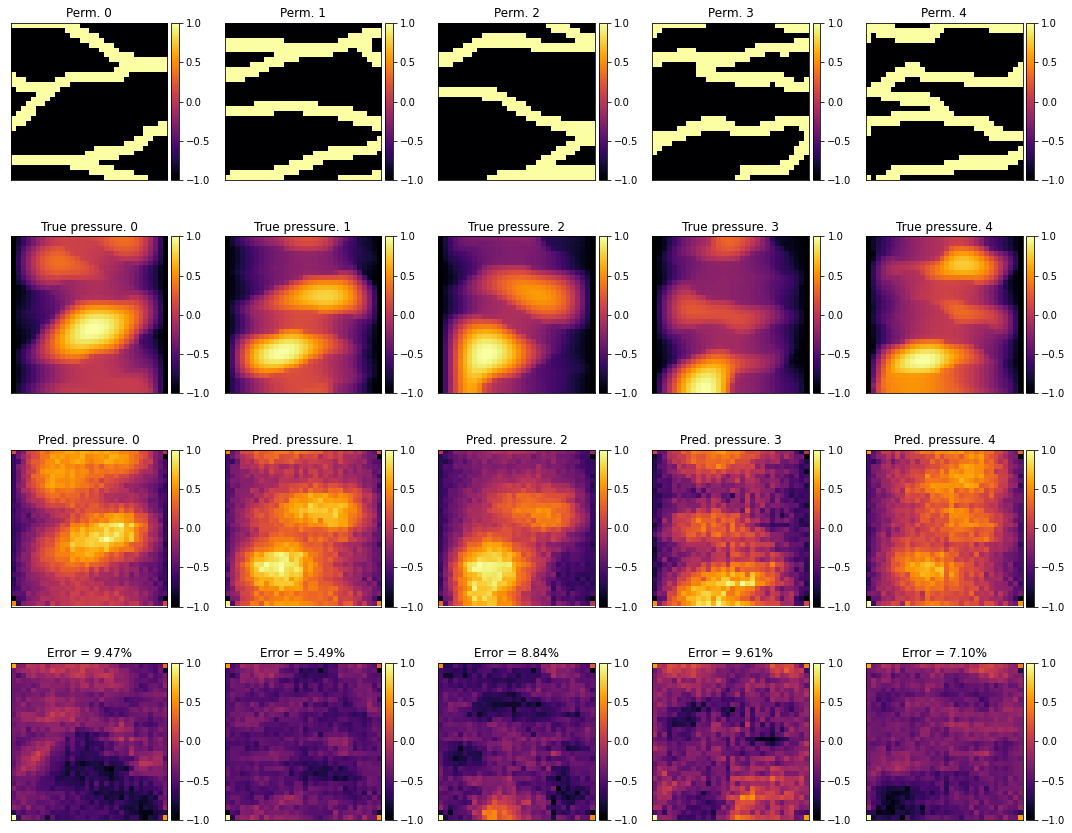

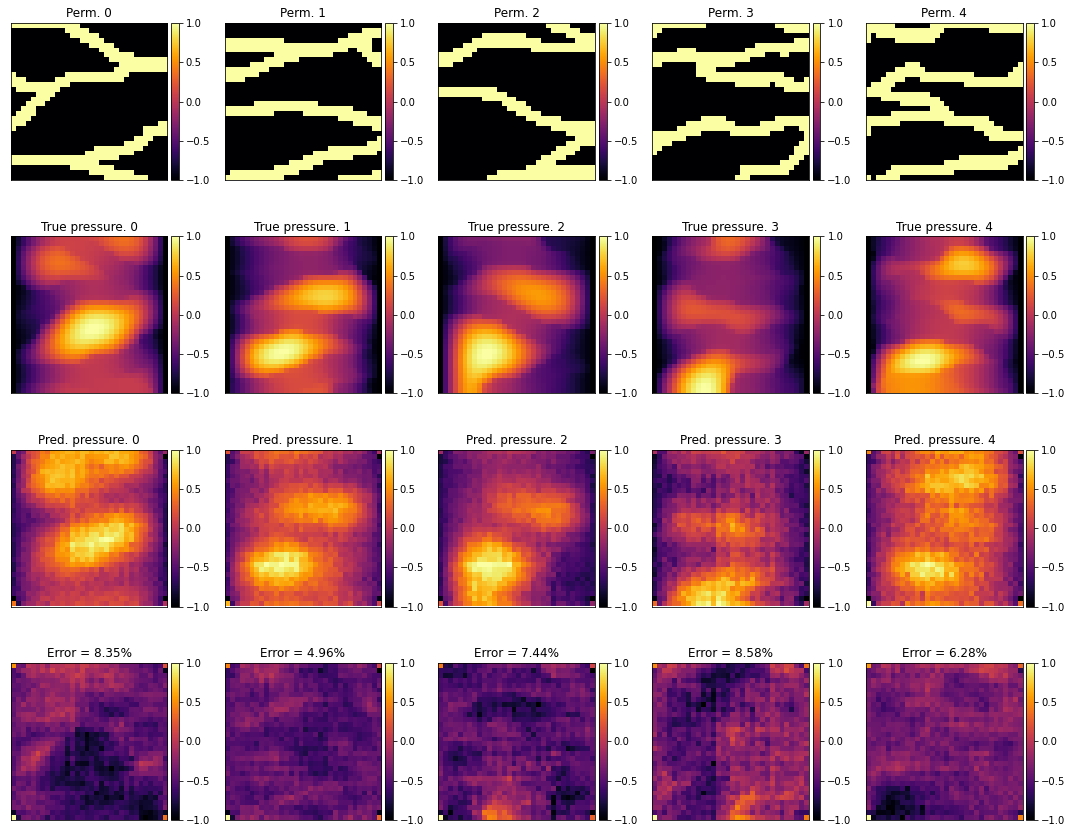

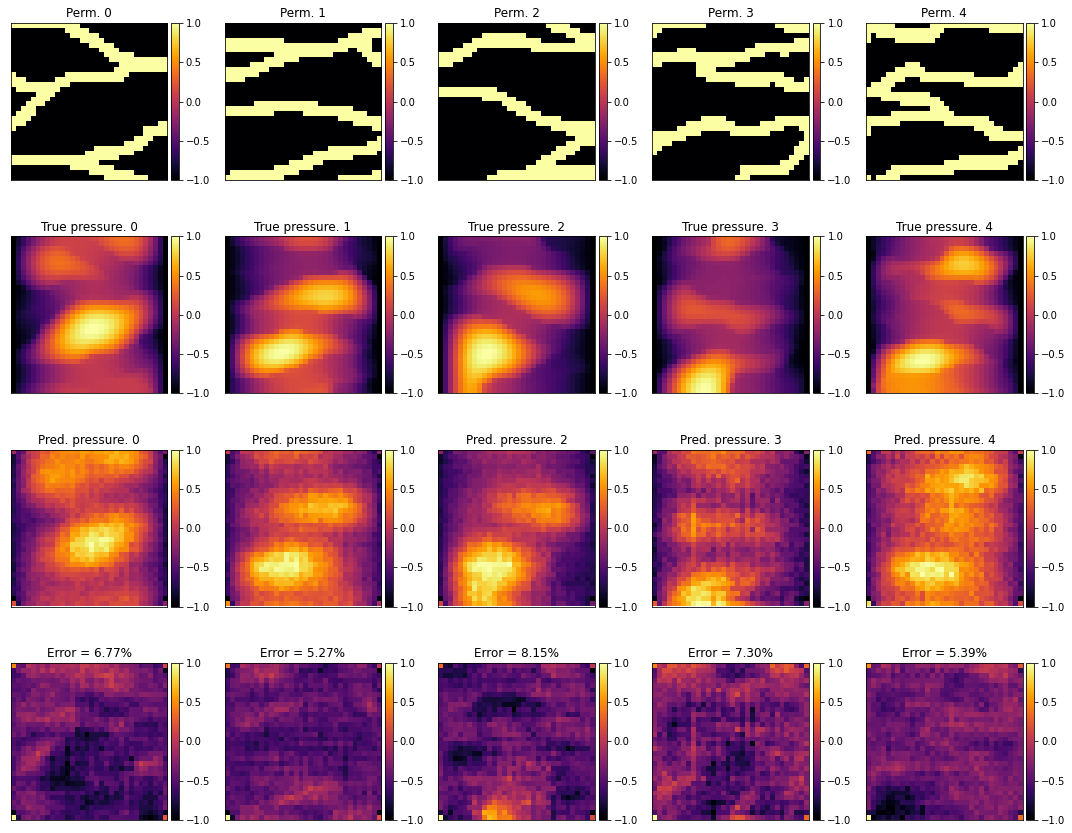

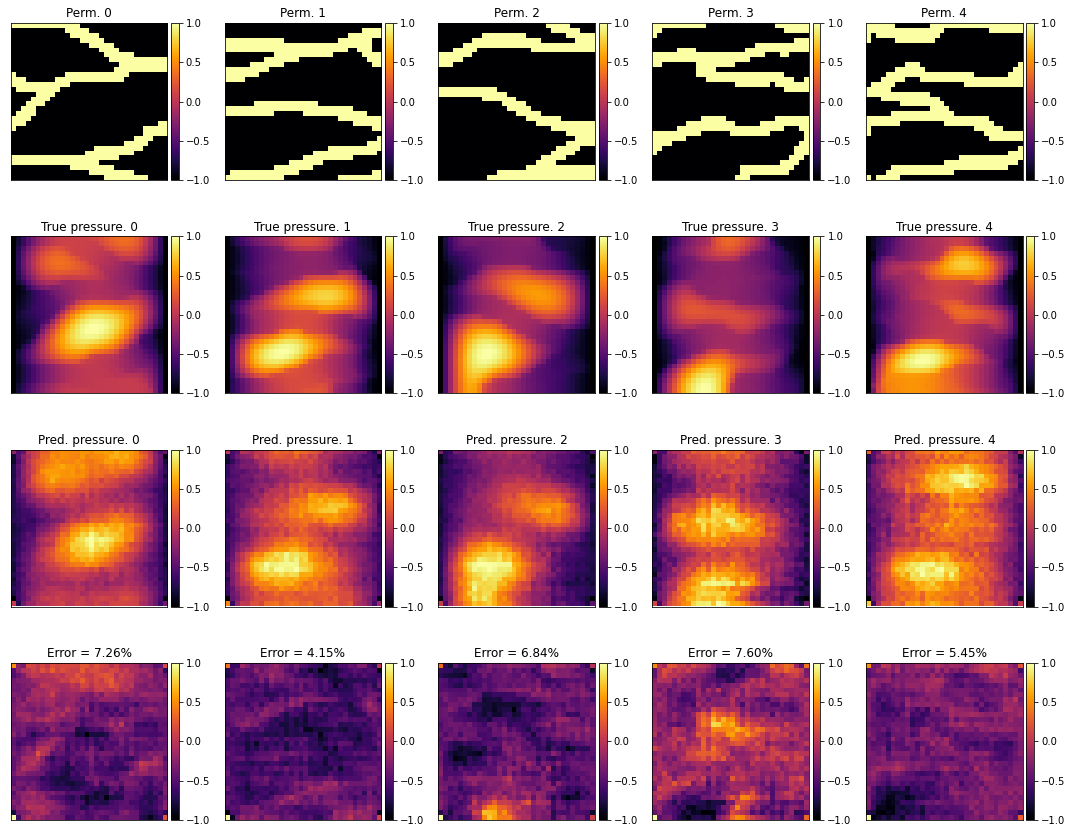

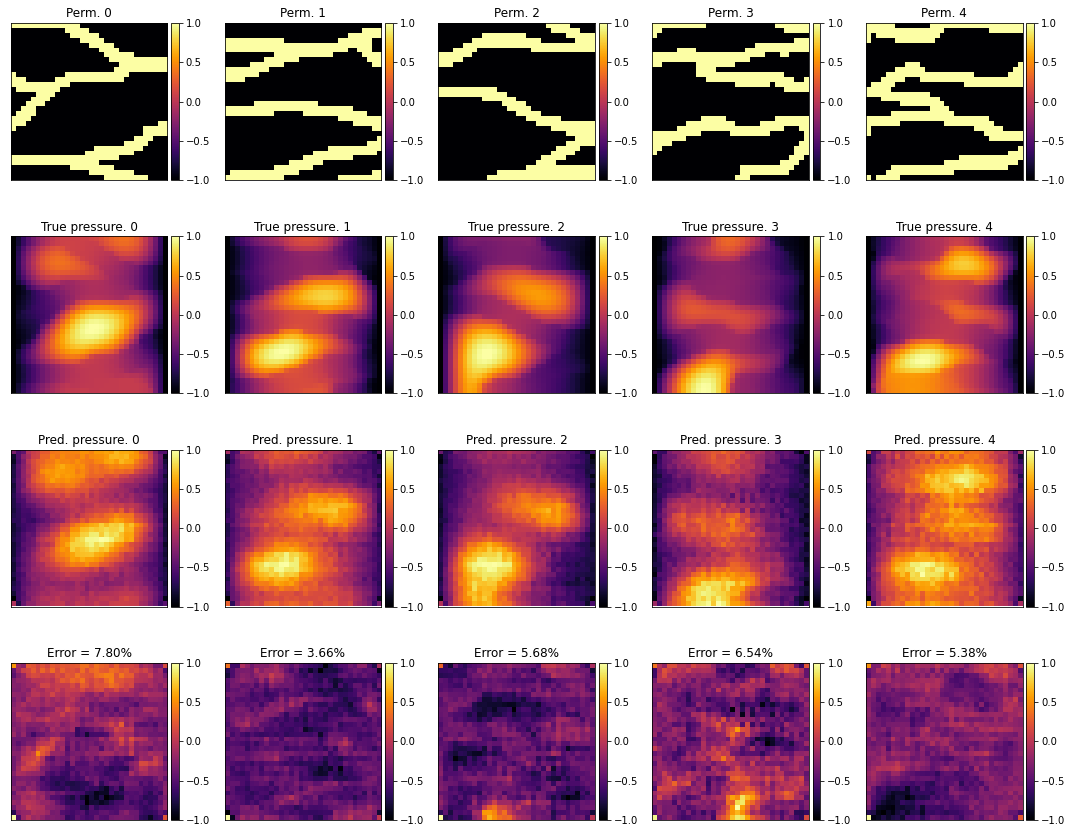

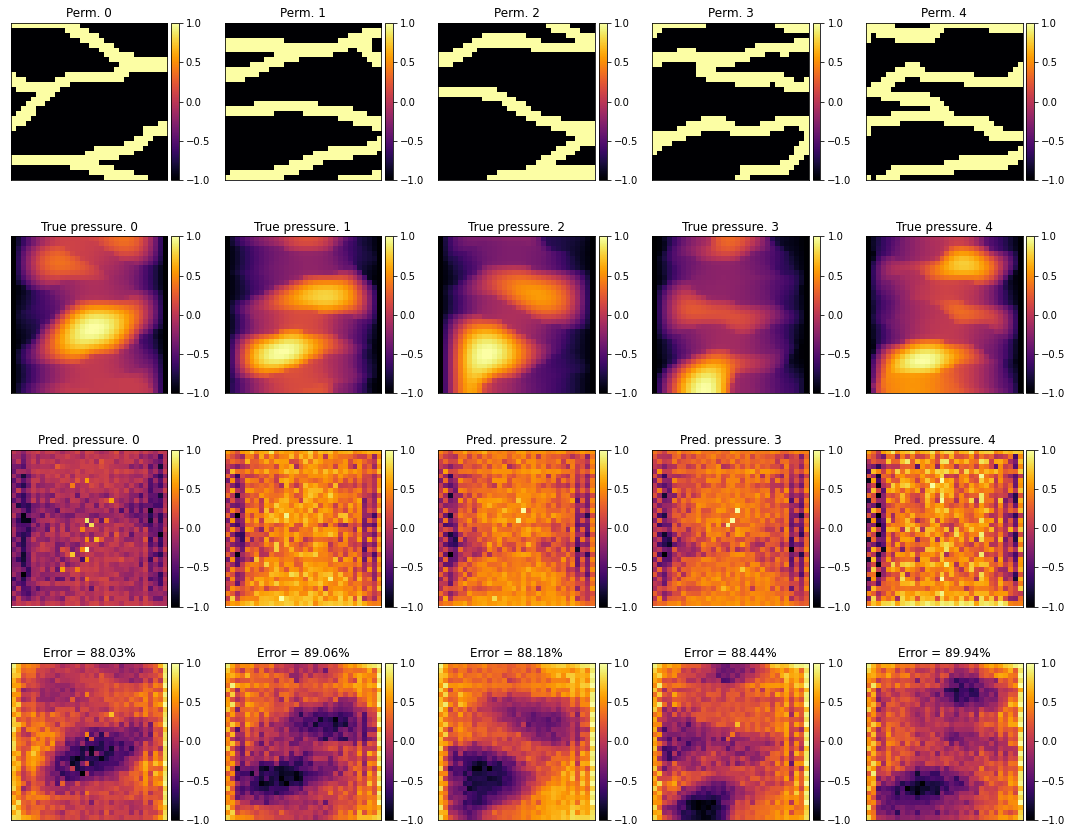

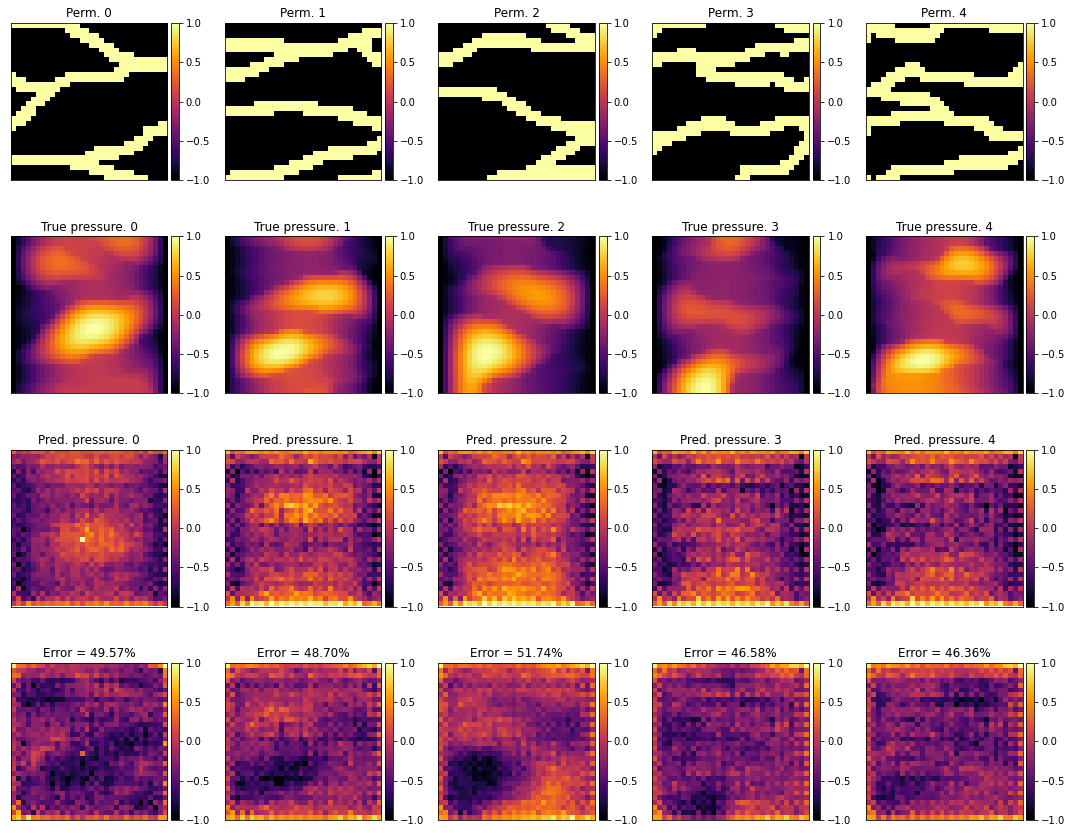

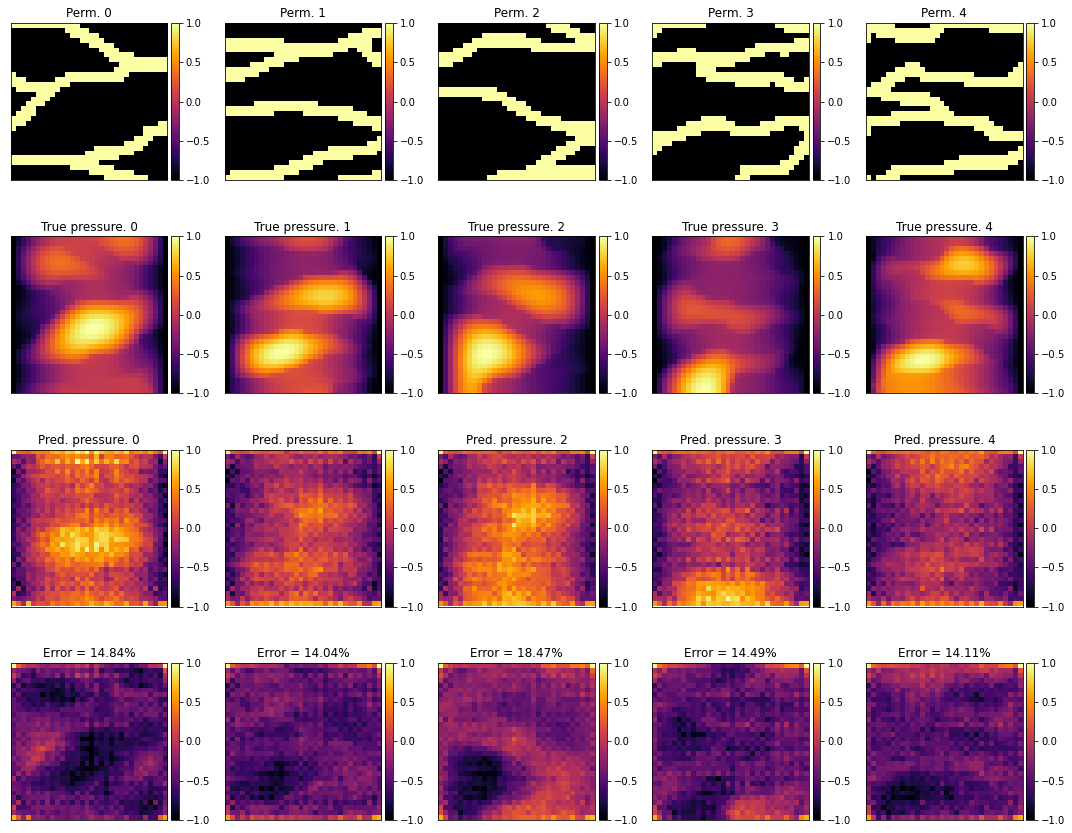

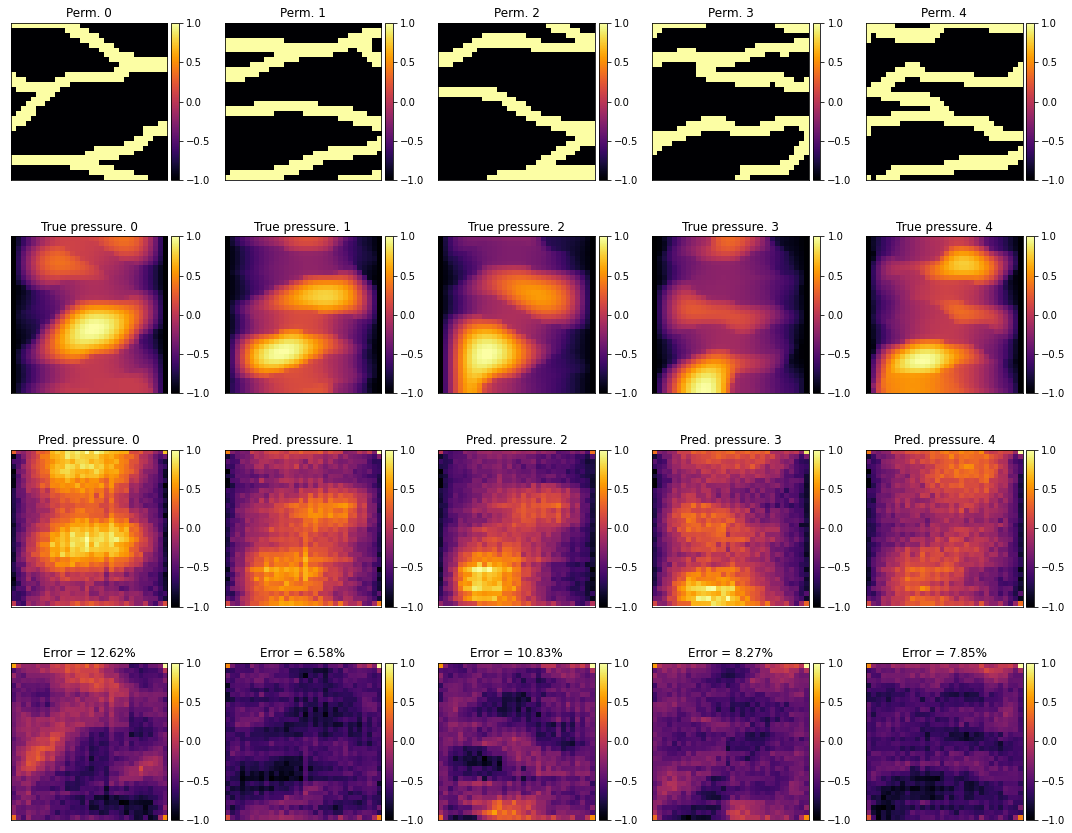

Error in callback <function flush_figures at 0x7fcf85281790> (for post_execute):


KeyboardInterrupt: 

In [50]:
t1 = time.time()
# ==============================================================================
# Training
# ==============================================================================
# Train the model
def train(config=None):
    # Initialize the new wandb run
    wandb.init(config=config, project=project_name, group=group_name) 
    config = wandb.config
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=config.batch_size,
                                                shuffle=True)
    total_step = len(train_loader)
    loss_list = []


    # Model, Loss, and Optimizer
    model = CAE(config.dim, config.h_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.reg_param)
    for epoch in range(num_epochs):
        for i, (train_x, train_y) in enumerate(train_loader):
            # Run the forward pass
            model.train()
            output = model(train_x.unsqueeze(1))
            loss = criterion(output, train_y.unsqueeze(1))
            loss_list.append(loss.item())
            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch+1) % log_freq == 0:
            # Calculate the validation loss
            model.eval()
            with torch.no_grad():
                val_pressure_pred = model(val_permeability.unsqueeze(1))                    
                val_loss = criterion(val_pressure_pred, val_pressure.unsqueeze(1))
            
            plot_perm_and_temp(val_permeability.detach().cpu().numpy().squeeze(), 
                                val_pressure.detach().cpu().numpy().squeeze(), 
                                val_pressure_pred.detach().cpu().numpy().squeeze(), epoch)
            diff_ = (val_pressure_pred - val_pressure.unsqueeze(1)).detach().cpu().numpy().squeeze()
            diff_vec = np.reshape(diff_, (diff_.shape[0], -1))
            val_l2_pt_error = np.mean(np.linalg.norm(diff_vec, axis=1) / np.linalg.norm(np.reshape(val_pressure.detach().cpu().numpy(), (val_pressure.shape[0], -1)), axis=1), axis=0) * 100
            val_indiv_rel_error = np.linalg.norm(diff_vec, axis=1) / np.linalg.norm(np.reshape(val_pressure.detach().cpu().numpy(), (val_pressure.shape[0], -1)), axis=1) * 100
            #table = wandb.Table(val_indiv_rel_error, "val_indiv_rel_error")

            wandb.log({"val_loss": val_loss.item(), "train_loss": loss.item(), "val_rel_error_pt": val_l2_pt_error, "val_indiv_rel_error_pt": val_indiv_rel_error, "epoch": epoch})
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], \
                    Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, \
                    Val. error (in %) = {val_l2_pt_error:.2f}%")

    # Save the model checkpoint (optional)
    save_path = os.path.join(wandb.run.dir, "model.ckpt")
    torch.save(model.state_dict(), save_path)

wandb.agent(sweep_id, train)
t2 = time.time()
print(f"Total time taken: {t2-t1}")
wandb.finish()